In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

In [2]:
spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 18:07:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#Read CSV Files of 2006,2007,2008 years and merge using union function 
df1 = spark.read.csv(path='/Users/csuftitan/Downloads/2006.csv', inferSchema=True, header=True)
df2 = spark.read.csv(path='/Users/csuftitan/Downloads/2007.csv', inferSchema=True, header=True)

df3 = spark.read.csv(path='/Users/csuftitan/Downloads/2008.csv', inferSchema=True, header=True)

resultMerge=df1.union(df2)
result=resultMerge.union(df3)

#store it in temporary view
result.registerTempTable("charts")  

22/12/08 18:07:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


/Users/csuftitan/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [4]:
result.head(50)

[Row(Year=2006, Month=1, DayofMonth=11, DayOfWeek=3, DepTime='743', CRSDepTime=745, ArrTime='1024', CRSArrTime=1018, UniqueCarrier='US', FlightNum=343, TailNum='N657AW', ActualElapsedTime='281', CRSElapsedTime='273', AirTime='223', ArrDelay='6', DepDelay='-2', Origin='ATL', Dest='PHX', Distance=1587, TaxiIn='45', TaxiOut='13', Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay='0', WeatherDelay='0', NASDelay='0', SecurityDelay='0', LateAircraftDelay='0'),
 Row(Year=2006, Month=1, DayofMonth=11, DayOfWeek=3, DepTime='1053', CRSDepTime=1053, ArrTime='1313', CRSArrTime=1318, UniqueCarrier='US', FlightNum=613, TailNum='N834AW', ActualElapsedTime='260', CRSElapsedTime='265', AirTime='214', ArrDelay='-5', DepDelay='0', Origin='ATL', Dest='PHX', Distance=1587, TaxiIn='27', TaxiOut='19', Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay='0', WeatherDelay='0', NASDelay='0', SecurityDelay='0', LateAircraftDelay='0'),
 Row(Year=2006, Month=1, DayofMonth=11, DayOfWeek=3, DepTi

In [5]:
result.registerTempTable("charts")

In [51]:
#Primary cause of delays was maximum due to which reason 
delayReason = spark.sql('''
Select sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM charts
''').toPandas()
display(delayReason)

,Weather,NAS,Security,lateAircraft,Carrier
0,12311139.0,63257423.0,445312.0,82513386.0,62272639.0


In [53]:
ReasonOfDelay= delayReason.values.tolist()
ReasonOfDelay

[[12311139.0, 63257423.0, 445312.0, 82513386.0, 62272639.0]]

In [54]:
flattened = []
for sublist in ReasonOfDelay:
    for val in sublist:
        flattened.append(val)

In [55]:
flattened

[12311139.0, 63257423.0, 445312.0, 82513386.0, 62272639.0]

In [56]:
x = ['WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','CarrierDelay']

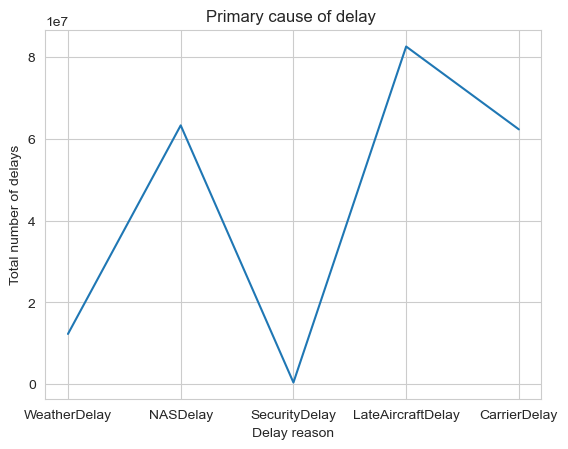

In [57]:

plt.plot(x, flattened)
plt.title('Primary cause of delay ')

plt.xlabel('Delay reason')
plt.ylabel('Total number of delays')
plt.show()

In [82]:
#Which flight were diverted 
df11=spark.sql('''
Select count(CarrierDelay) as Diverted from charts where CarrierDelay = '1'
''').toPandas()

In [49]:
#Which flight were not diverted 
df12=spark.sql('''
Select count(CarrierDelay) as NotDiverted from charts where CarrierDelay = '0'
''').toPandas()

In [84]:
df11

,Diverted
0,46640


In [94]:
#which airports have more delay  based on the origin of the airport location 
AirportDelay = spark.sql("SELECT Origin,avg(DepDelay) delay \
                                FROM charts \
                                GROUP BY Origin")

In [95]:
res=AirportDelay.toPandas()

In [126]:
res1=res.head(5)
display(res1)

,Origin,delay
0,BGM,9.458496
1,DLG,13.888312
2,PSE,2.591202
3,MSY,9.047962
4,GEG,5.430236


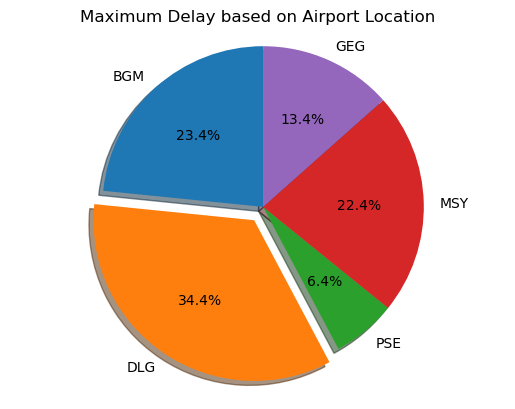

In [138]:
import matplotlib.pyplot as plt
 

 
plt.pie(res1['delay'], labels=res1['Origin'], autopct='%1.1f%%', explode=[0,0.1,0,0,0], shadow=True, startangle=90)
plt.title('Maximum Delay based on Airport Location')
plt.axis('equal')
plt.show()

In [152]:
# Delay caused due to air carrier and which aircraft caused more delay 
AircraftDelay = spark.sql("select UniqueCarrier,count(UniqueCarrier) ,avg(DepDelay) delay from charts Group By UniqueCarrier")

In [153]:
aircraftdelay = AircraftDelay.toPandas()

In [154]:
aircraftdelay.head(5)

,UniqueCarrier,count(UniqueCarrier),delay
0,UA,1144046,13.319730
1,AA,1481973,13.093971
2,NW,970205,7.971171
3,EV,651760,17.812001
4,B6,414660,12.989345


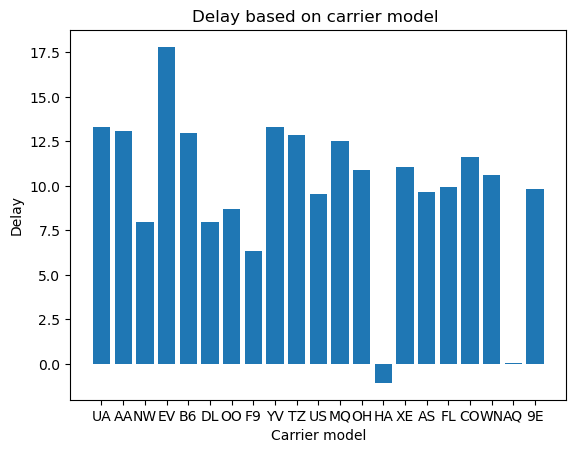

In [156]:
import matplotlib.pyplot as plt
plt.bar(aircraftdelay['UniqueCarrier'],aircraftdelay['delay'])
plt.title('Delay based on carrier model ')
plt.xlabel('Carrier model')
plt.ylabel('Delay')
plt.show()

In [158]:
yeardelay.toPandas()

,year,avg(DepDelay)
0,2006,10.093642
1,2007,11.399142
2,2008,11.436359


In [192]:
#How much delay each carrier has in a Year
YearDelay = spark.sql("Select UniqueCarrier, Year, avg(DepDelay)Delay from charts group by UniqueCarrier,Year")

In [193]:
s=YearDelay.toPandas()

Text(0.5, 1.0, 'How much delay does each carrier has in each Year?')

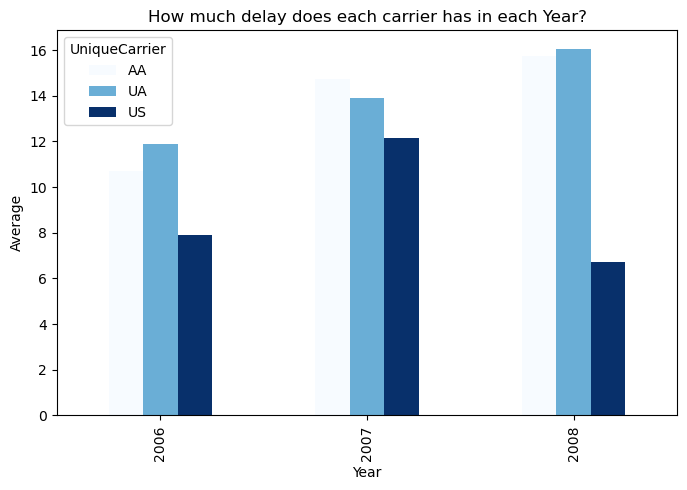

In [195]:
from pylab import rcParams
ps = s.pivot(index='Year', columns='UniqueCarrier', values='Delay')[['AA','UA','US']]


     

rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Blues');
plt.xlabel('Year')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each Year?')


In [96]:
#Delay a carrier has in a month 
MonthDelay = spark.sql("Select UniqueCarrier, Month, avg(DepDelay)Delay from charts group by UniqueCarrier,Month Order by Month")

In [97]:
p=MonthDelay.toPandas()
display(p)

,UniqueCarrier,Month,Delay
0,AS,1,10.039399
1,F9,1,6.160997
2,UA,1,13.921817
3,XE,1,8.413694
4,YV,1,13.409783
...,...,...,...
247,AA,12,18.154304
248,OO,12,15.926613
249,YV,12,18.282044
250,DL,12,7.662602


In [98]:
p.loc[p["Month"] == 1, "Month"] = 'Jan'
p.loc[p["Month"] == 2, "Month"] = 'Feb'
p.loc[p["Month"] == 3, "Month"] = 'Mar'
p.loc[p["Month"] == 4, "Month"] = 'Apr'
p.loc[p["Month"] == 5, "Month"] = 'May'
p.loc[p["Month"] == 6, "Month"] = 'Jun'
p.loc[p["Month"] == 7, "Month"] = 'Jul'
p.loc[p["Month"] == 8, "Month"] = 'Aug'
p.loc[p["Month"] == 9, "Month"] = 'Sept'
p.loc[p["Month"] == 10, "Month"] = 'Oct'
p.loc[p["Month"] == 11, "Month"] = 'Nov'
p.loc[p["Month"] == 12, "Month"] = 'Dec'


In [99]:
p

,UniqueCarrier,Month,Delay
0,AS,Jan,10.039399
1,F9,Jan,6.160997
2,UA,Jan,13.921817
3,XE,Jan,8.413694
4,YV,Jan,13.409783
...,...,...,...
247,AA,Dec,18.154304
248,OO,Dec,15.926613
249,YV,Dec,18.282044
250,DL,Dec,7.662602


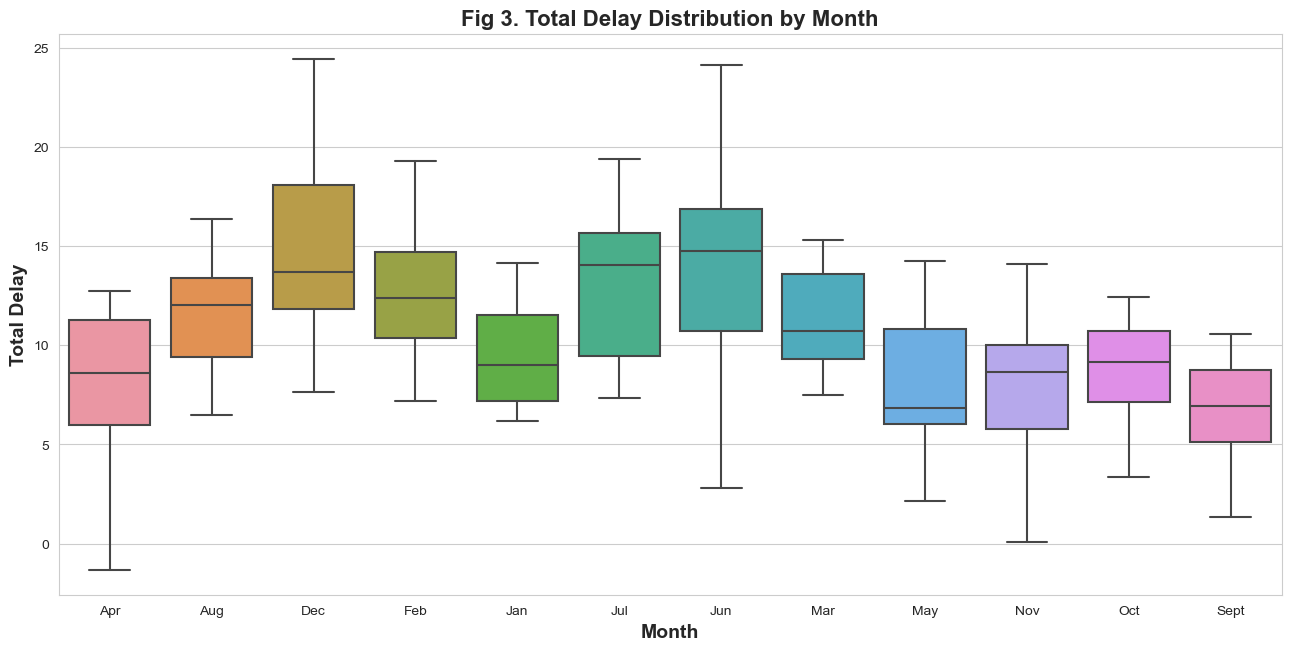

In [102]:
sns.set_style("whitegrid")
fig3, ax3 = plt.subplots(figsize=(12.8, 6.4), constrained_layout=True)
ax3 = sns.boxplot(x="Month", y="Delay", order=np.sort(p["Month"].unique()), data=p[["Delay", "Month"]], showfliers=False)
ax3.set_title("Fig 3. Total Delay Distribution by Month", fontdict={"weight": "bold", "fontsize": 16})
ax3.set_xlabel("Month", fontdict={"weight": "bold", "fontsize": 14})
#ax3.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax3.set_ylabel("Total Delay", fontdict={"weight": "bold", "fontsize": 14})
pass

In [125]:
#Total Delay distribution in week 

WeekDelay = spark.sql("Select DayOfWeek,avg(DepDelay) Delay from charts group by DayOfWeek order by DayOfWeek")
weekdelay=WeekDelay.toPandas()
display(weekdelay)

,DayOfWeek,Delay
0,1,11.234814
1,2,8.944824
2,3,9.751114
3,4,12.168855
4,5,13.535107
5,6,8.827386
6,7,11.196872


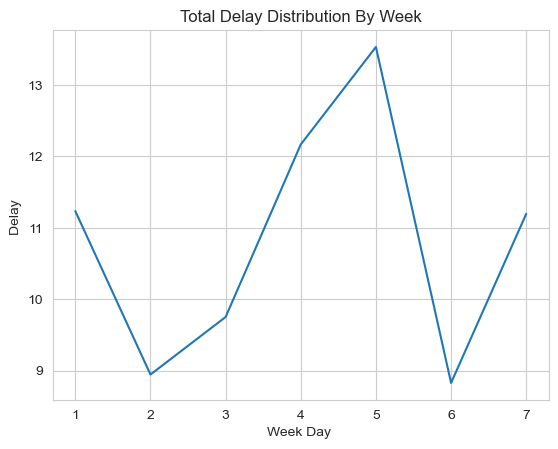

In [131]:
import matplotlib.pyplot as plt
import numpy as np
  
  
x = weekdelay['DayOfWeek']
y = weekdelay['Delay']
  
plt.plot(x, y)
plt.xlabel("Week Day ")
plt.ylabel("Delay ")
plt.title("Total Delay Distribution By Week")
plt.show()  # show first chart

In [37]:
#Total distribution delay in a month 
month = spark.sql("Select CRSDepTime,(ActualElapsedTime - CRSElapsedTime) as totalDelay from charts")
#month.toPandas().head(10)



In [38]:
month=month.toPandas()
display(month)

,CRSDepTime,totalDelay
0,745,8.0
1,1053,-5.0
2,1915,-23.0
3,1755,-6.0
4,832,8.0
...,...,...
16984349,1025,-3.0
16984350,1320,4.0
16984351,1335,3.0
16984352,1935,1.0


In [39]:
def get_hour(time):
    return "00" if str(time)[:-2] == "24" else str(time)[:-2].zfill(2)



In [40]:
month["hr"] = month["CRSDepTime"].apply(get_hour)

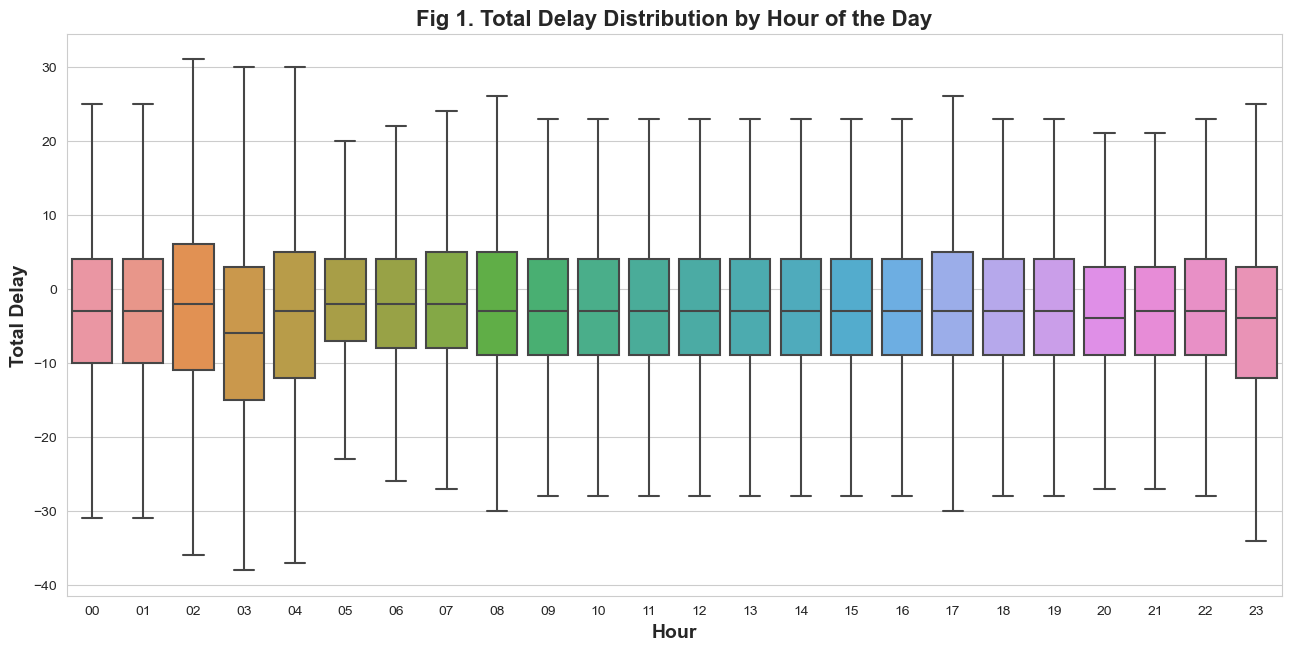

In [42]:
sns.set_style("whitegrid")
fig1, ax1 = plt.subplots(figsize=(12.8, 6.4), constrained_layout=True)
ax1 = sns.boxplot(x="hr", y="totalDelay", order=np.sort(month["hr"].unique()), data=month[["totalDelay", "hr"]], showfliers=False)
ax1.set_title(" Total Delay Distribution by Hour of the Day", fontdict={"weight": "bold", "fontsize": 16})
ax1.set_xlabel("Hour", fontdict={"weight": "bold", "fontsize": 14})
ax1.set_ylabel("Total Delay", fontdict={"weight": "bold", "fontsize": 14})
pass

In [46]:
#Total distribution in a week 
dayOfWeek = spark.sql("Select  DayOfWeek,(ActualElapsedTime - CRSElapsedTime) as totalDelay from charts")



In [47]:
dayOfWeek=dayOfWeek.toPandas()
display(dayOfWeek)

,DayOfWeek,totalDelay
0,3,8.0
1,3,-5.0
2,3,-23.0
3,3,-6.0
4,3,8.0
...,...,...
16984349,4,-3.0
16984350,4,4.0
16984351,4,3.0
16984352,4,1.0


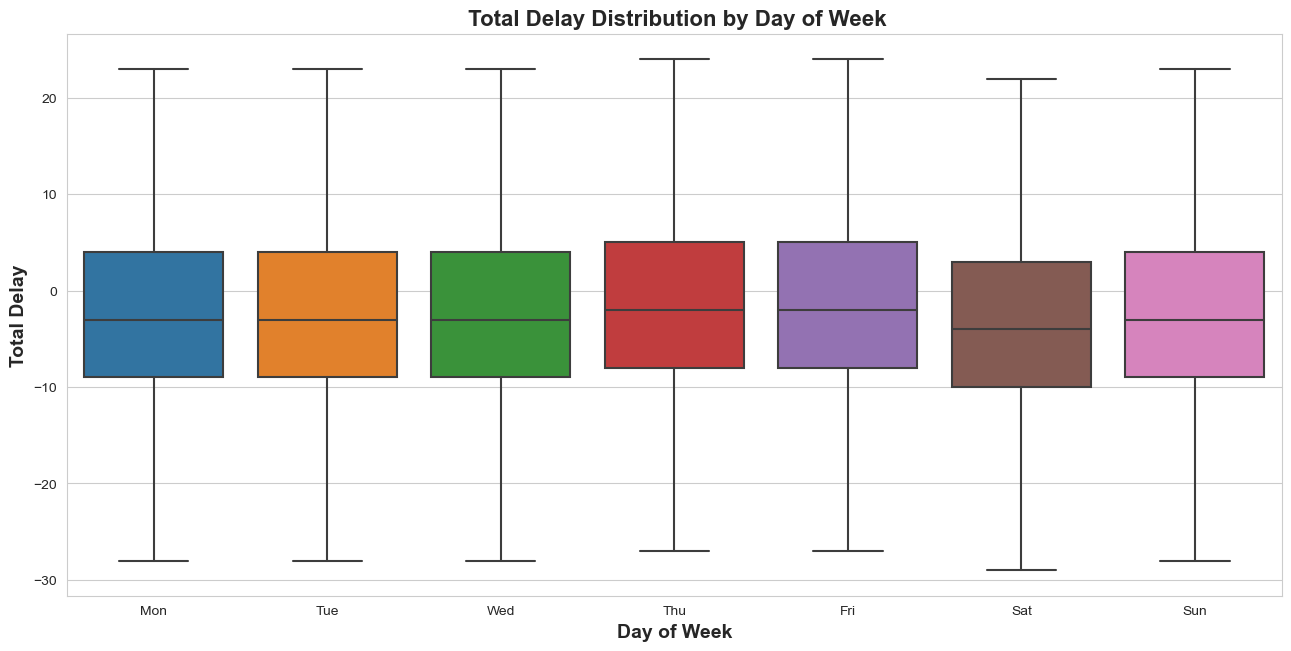

22/12/08 21:17:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 122335 ms exceeds timeout 120000 ms
22/12/08 21:17:09 WARN SparkContext: Killing executors is not supported by current scheduler.


In [49]:
sns.set_style("whitegrid")
fig2, ax2 = plt.subplots(figsize=(12.8, 6.4), constrained_layout=True)
ax2 = sns.boxplot(x="DayOfWeek", y="totalDelay", order=np.sort(dayOfWeek["DayOfWeek"].unique()), data=dayOfWeek[["totalDelay", "DayOfWeek"]], showfliers=False)
ax2.set_title(" Total Delay Distribution by Day of Week", fontdict={"weight": "bold", "fontsize": 16})
ax2.set_xlabel("Day of Week", fontdict={"weight": "bold", "fontsize": 14})
ax2.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax2.set_ylabel("Total Delay", fontdict={"weight": "bold", "fontsize": 14})
pass